# Part A

# • DOMAIN: Entertainment
# • CONTEXT: Company X owns a movie application and repository which caters movie streaming to millions of users who on subscription basis. Company wants to automate the process of cast and crew information in each scene from a movie such that when a user pauses on the movie and clicks on cast information button, the app will show details of the actor in the scene. Company has an in-house computer vision and multimedia experts who need to detect faces from screen shots from the movie scene.

# The data labelling is already done. Since there higher time complexity is involved in the
# • DATA DESCRIPTION: The dataset comprises of images and its mask for corresponding human face.
# • PROJECT OBJECTIVE: To build a face detection system.

# Steps and tasks:

# 1. Import and Understand the data

# A. Import and read ‘images.npy’.

In [228]:
# IMPORT ALL THE REQUIRED LIBRARIES INTO THE NOTEBOOK

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from IPython.display import SVG

from keras.utils import plot_model
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from tensorflow.keras.applications.mobilenet import preprocess_input

from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam,SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.layers import Input, Add, Activation, GlobalMaxPooling2D
from keras.models import Sequential, Model

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import BatchNormalization

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from keras.initializers import *
import cv2

In [2]:
DATA = np.load("images.npy", allow_pickle=True)

In [3]:
DATA.shape

(409, 2)

In [4]:
IMAGES = DATA[:,0]
MASK = DATA[:,1]

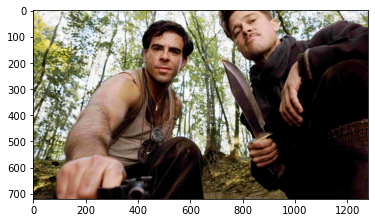

In [5]:
plt.imshow(IMAGES[256])

In [6]:
display(MASK[256])

[{'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.34607438016528924, 'y': 0.1488970588235294},
   {'x': 0.44214876033057854, 'y': 0.3694852941176471}],
  'imageWidth': 1280,
  'imageHeight': 720},
 {'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.5774793388429752, 'y': 0.012867647058823529},
   {'x': 0.7231404958677686, 'y': 0.24080882352941177}],
  'imageWidth': 1280,
  'imageHeight': 720}]

# B. Split the data into Features(X) & labels(Y). Unify shape of all the images.

In [7]:
# SET IMAGE WIDTH AND IMAGE HEIGHT TO 224X224

IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
ALPHA = 1

IMAGE_MASK = np.zeros((int(DATA.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
IMAGES = np.zeros((int(DATA.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))

for i in range(DATA.shape[0]):
    IMG = DATA[i][0]
    IMG = cv2.resize(IMG, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    try:
        IMG = IMG[:, :, :3]
    except:
        IMG = cv2.cvtColor(IMG, cv2.COLOR_GRAY2RGB)
        continue
    IMAGES[i] = preprocess_input(np.array(IMG, dtype=np.float32))
    for j in DATA[i][1]:
        X1 = int(j['points'][0]['x'] * IMAGE_WIDTH)
        Y1 = int(j['points'][0]['y'] * IMAGE_WIDTH)
        X2 = int(j['points'][1]['x'] * IMAGE_HEIGHT)
        Y2 = int(j['points'][1]['y'] * IMAGE_HEIGHT)
        IMAGE_MASK[i][Y1:Y2, X1:X2] = 1

In [8]:
print("SHAPE OF IMAGES / FEATURES: ",IMAGES.shape)

print("SHAPE OF IMAGE MASK / LABELS: ",IMAGE_MASK.shape)

SHAPE OF IMAGES / FEATURES:  (409, 224, 224, 3)
SHAPE OF IMAGE MASK / LABELS:  (409, 224, 224)


# C. Split the data into train and test[400:9]

In [9]:
#X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(IMAGES, IMAGE_MASK, test_size=0.022)

X_TRAIN = IMAGES[:400]
X_TEST = IMAGES[400:410]
Y_TRAIN = IMAGE_MASK[:400]
Y_TEST = IMAGE_MASK[400:410]

In [10]:
print('SHAPE OF X_TRAIN: ',X_TRAIN.shape)
print('\nSHAPE OF Y_TRAIN: ',Y_TRAIN.shape)
print('\nSHAPE OF X_TEST: ',X_TEST.shape)
print('\nSHAPE OF Y_TEST: ',Y_TEST.shape)

SHAPE OF X_TRAIN:  (400, 224, 224, 3)

SHAPE OF Y_TRAIN:  (400, 224, 224)

SHAPE OF X_TEST:  (9, 224, 224, 3)

SHAPE OF Y_TEST:  (9, 224, 224)


# D. Select random image from the train data and display original image and masked image.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


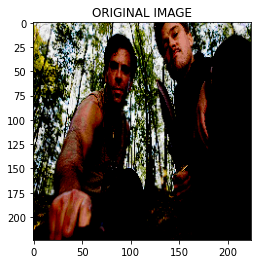

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


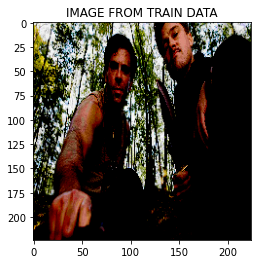

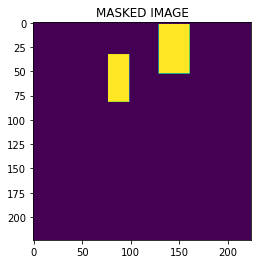

In [11]:
IMG_NUM = 256

plt.imshow(IMAGES[IMG_NUM])
plt.title('ORIGINAL IMAGE')
plt.show()

plt.imshow(X_TRAIN[IMG_NUM])
plt.title('IMAGE FROM TRAIN DATA')
plt.show()

plt.imshow(Y_TRAIN[IMG_NUM])
plt.title('MASKED IMAGE')
plt.show()

# 2. Model building

# A. Design a face mask detection model.

In [12]:
from tensorflow.keras.applications import MobileNet

MOBILE = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, alpha=ALPHA, weights="imagenet")

In [13]:
MOBILE.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

In [14]:
from tensorflow.keras.layers import Concatenate, UpSampling2D, Reshape

def CREATE_MODEL(TRAINABLE = True):
    
    TRAINABLE = False
    
    for layer in MOBILE.layers:
        layer.trainable = TRAINABLE

    LAYER_00 = MOBILE.layers[0].input
    LAYER_01 = MOBILE.get_layer("conv_pw_1_relu").output
    LAYER_02 = MOBILE.get_layer("conv_pw_2_relu").output
    LAYER_03 = MOBILE.get_layer("conv_pw_3_relu").output
    LAYER_04 = MOBILE.get_layer("conv_pw_5_relu").output
    LAYER_05 = MOBILE.get_layer("conv_pw_11_relu").output
    LAYER_06 = MOBILE.get_layer("conv_pw_13_relu").output

    DECODE_LAYER = Concatenate()([UpSampling2D()(LAYER_06), LAYER_05])
    DECODE_LAYER = Concatenate()([UpSampling2D()(DECODE_LAYER), LAYER_04])
    DECODE_LAYER = Concatenate()([UpSampling2D()(DECODE_LAYER), LAYER_03])
    DECODE_LAYER = Concatenate()([UpSampling2D()(DECODE_LAYER), LAYER_01])
    DECODE_LAYER = Concatenate()([UpSampling2D()(DECODE_LAYER), LAYER_00])

    DECODE_LAYER = Conv2D(1, kernel_size=1, activation="sigmoid")(DECODE_LAYER)
    DECODE_LAYER = Reshape((IMAGE_HEIGHT, IMAGE_WIDTH))(DECODE_LAYER)
    
    return Model(MOBILE.input, outputs = DECODE_LAYER)

# B. Design your own Dice Coefficient and Loss function.

In [15]:
def dice_coefficient(Y_TRUE, Y_PRED):
    numerator = 2 * tensorflow.reduce_sum(Y_TRUE * Y_PRED)
    denominator = tensorflow.reduce_sum(Y_TRUE + Y_PRED)

    return numerator / (denominator + tensorflow.keras.backend.epsilon())

In [16]:
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - tensorflow.keras.backend.log(dice_coefficient(y_true, y_pred) + 
                                                                              tensorflow.keras.backend.epsilon())

# C. Train and tune the model as required.

In [17]:
UNET_MOBILE = CREATE_MODEL(False)

UNET_MOBILE.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 112, 112, 32  128         ['conv1[0][0]']                  
                                )                                                             

In [18]:
from tensorflow.keras.losses import binary_crossentropy

optimizer = Adam(learning_rate = 1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

UNET_MOBILE.compile(loss=loss, optimizer=optimizer, metrics=[dice_coefficient])

In [19]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("UNET_MOBILE-{loss:.2f}.h5", monitor="loss", verbose=1, 
                             save_best_only=True, save_weights_only=True)

stop = EarlyStopping(monitor="loss", patience=5)

reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1)

In [20]:
import tensorflow

UNET_MOBILE.fit(X_TRAIN, Y_TRAIN, epochs = 5, verbose = 1, batch_size = 3, callbacks = [checkpoint, reduce_lr, stop])

Epoch 1/5
134/134 [==============================] - ETA: 0s - loss: 1.9519 - dice_coefficient: 0.2598
Epoch 1: loss improved from inf to 1.95189, saving model to UNET_MOBILE-1.95.h5
134/134 [==============================] - 487s 4s/step - loss: 1.9519 - dice_coefficient: 0.2598 - lr: 1.0000e-04
Epoch 2/5
134/134 [==============================] - ETA: 0s - loss: 1.3809 - dice_coefficient: 0.3709
Epoch 2: loss improved from 1.95189 to 1.38087, saving model to UNET_MOBILE-1.38.h5
134/134 [==============================] - 495s 4s/step - loss: 1.3809 - dice_coefficient: 0.3709 - lr: 1.0000e-04
Epoch 3/5
134/134 [==============================] - ETA: 0s - loss: 1.1628 - dice_coefficient: 0.4377
Epoch 3: loss improved from 1.38087 to 1.16275, saving model to UNET_MOBILE-1.16.h5
134/134 [==============================] - 506s 4s/step - loss: 1.1628 - dice_coefficient: 0.4377 - lr: 1.0000e-04
Epoch 4/5
134/134 [==============================] - ETA: 0s - loss: 1.0115 - dice_coefficient: 0.

# D. Evaluate and share insights on performance of the model.

In [21]:
#TRAIN_LOSS, TRAIN_ACCURACY = UNET_MOBILE.evaluate(X_TRAIN, Y_TRAIN, verbose=1)


#print('TRAIN LOSS:', TRAIN_LOSS)
#print('TRAIN ACCURACY:', TRAIN_ACCURACY)

In [22]:
TEST_LOSS, TEST_ACCURACY = UNET_MOBILE.evaluate(X_TEST, Y_TEST, verbose=1)

print('TEST LOSS:', TEST_LOSS)
print('TEST ACCURACY:', TEST_ACCURACY)

1/1 [==============================] - 10s 10s/step - loss: 0.8121 - dice_coefficient: 0.5393
TEST LOSS: 0.8121198415756226
TEST ACCURACY: 0.5392839908599854


# 3. Test the model predictions on the test image: ‘image with index 3 in the test data’ and visualise the predicted masks on the faces in the image.

In [158]:
PRED_IMAGES = UNET_MOBILE.predict(X_TEST,verbose = 1)

PRED_IMAGES[1].shape

1/1 [==============================] - 7s 7s/step


(224, 224)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


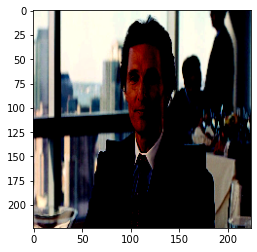

In [159]:
plt.imshow(X_TEST[3])

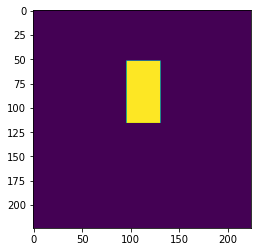

In [161]:
plt.imshow(Y_TEST[3])

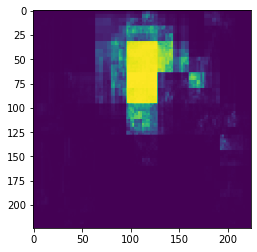

In [160]:
plt.imshow(PRED_IMAGES[3])

# Part B

# • DOMAIN: Entertainment

# • CONTEXT: Company X owns a movie application and repository which caters movie streaming to millions of users who on subscription basis. Company wants to automate the process of cast and crew information in each scene from a movie such that when a user pauses on the movie and clicks on cast information button, the app will show details of the actor in the scene. Company has an in-house computer vision and multimedia experts who need to detect faces from screen shots from the movie scene. The data labelling is already done. Since there higher time complexity is involved in the
# • DATA DESCRIPTION: The dataset comprises of face images.
# • PROJECT OBJECTIVE: To create an image dataset to be used by AI team build an image classifier data. Profile images of people are given.

# Steps and tasks:

# 1. Read/import images from folder ‘training_images’.

In [23]:
from zipfile import ZipFile

file_name = "training_images-20211126T092819Z-001.zip"

with ZipFile(file_name, 'r') as zip:
    
    zip.printdir()
    
    print('Extracting all the files now...')
    
    zip.extractall()
    
    print('Done!')

File Name                                             Modified             Size
training_images/real_00947.jpg                 2019-10-16 04:27:36       165936
training_images/real_01052.jpg                 2019-10-16 04:27:36        99194
training_images/real_01042.jpg                 2019-10-16 04:27:36       132379
training_images/real_00964.jpg                 2019-10-16 04:27:36       137657
training_images/real_01053.jpg                 2019-10-16 04:27:36        88502
training_images/real_00971.jpg                 2019-10-16 04:27:36        68693
training_images/real_01057.jpg                 2019-10-16 04:27:36       163006
training_images/real_01044.jpg                 2019-10-16 04:27:36       111944
training_images/real_01041.jpg                 2019-10-16 04:27:36       158596
training_images/real_01067.jpg                 2019-10-16 04:27:36       116880
training_images/real_00969.jpg                 2019-10-16 04:27:36       111096
training_images/real_00956.jpg          

# 2. Write a loop which will iterate through all the images in the ‘training_images’ folder and detect the faces present on all the images.

In [25]:
pip install opencv-contrib-python

Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 42.5/42.5 MB 2.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [30]:
from glob import glob

import cv2

from sklearn.datasets import load_files

PATH = 'training_images/*.jpg'

ALL_IMAGES = glob(PATH)

IMG_FOR_TRAIN = []

for i in ALL_IMAGES:
    IMG_FOR_TRAIN.append(cv2.resize(cv2.imread(i),(224,224)))
    
IMAGE_DATA = np.asarray(IMG_FOR_TRAIN)

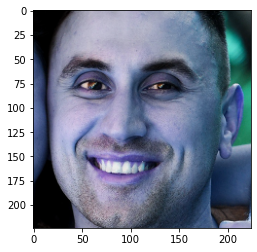

In [34]:
plt.imshow(IMAGE_DATA[128])

In [41]:
face_detector=cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

META_DATA = []

for i in ALL_IMAGES:
    IMG = cv2.resize(cv2.imread(i),(256,256))
    GRAY_IMAGE = cv2.cvtColor(IMG, cv2.COLOR_BGR2GRAY)
    FACE = face_detector.detectMultiScale(GRAY_IMAGE, 1.3, 5)
    
    for (x,y,w,h) in FACE:
        META_DATA.append(cv2.rectangle(IMG,(x,y),(x+w,y+h),(0,255,0),2))

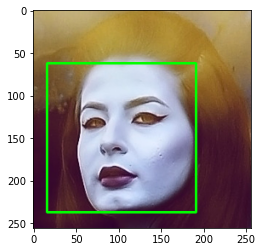

In [45]:
plt.imshow(META_DATA[125])

# 3. From the same loop above, extract metadata of the faces and write into a DataFrame.

In [144]:
FACES_DATA = []
TOTAL_FACES = []
IMAGE_NAMES = []
x = []
y = []
w = []
h = []
j = 0

for i in ALL_IMAGES:
    IMG = cv2.resize(cv2.imread(i),(256,256))
    GRAY_IMAGE = cv2.cvtColor(IMG, cv2.COLOR_BGR2GRAY)
    FACE = np.array(face_detector.detectMultiScale(GRAY_IMAGE, 1.3, 5))
    FACES_DATA.append(FACE)
    TOTAL_FACES.append(FACE.shape[0])
    IMAGE_NAMES.append(i.split('\\')[-1])
    if FACE.shape[0] > 0:
        x.append(np.array(FACES_DATA[j])[0][0])
        y.append(np.array(FACES_DATA[j])[0][1])
        w.append(np.array(FACES_DATA[j])[0][2])
        h.append(np.array(FACES_DATA[j])[0][3])
    else:
        x.append(0)
        y.append(0)
        w.append(0)
        h.append(0)
    j = j+1

In [145]:
x = pd.Series(x)
y = pd.Series(y)
w = pd.Series(w)
h = pd.Series(h)
TOTAL_FACES = pd.Series(TOTAL_FACES)
IMAGE_NAMES = pd.Series(IMAGE_NAMES)

DF = { 'x': x, 'y': y, 'w': w, 'h': h, 'Total_Faces': TOTAL_FACES, 'Image_Name': IMAGE_NAMES }

METADATA_DF = pd.DataFrame(DF)

In [147]:
print(METADATA_DF.head())

    x   y    w    h  Total_Faces      Image_Name
0  50  50  196  196            1  real_00001.jpg
1  32  57  190  190            1  real_00002.jpg
2  10  51  157  157            1  real_00003.jpg
3  55  69  160  160            1  real_00004.jpg
4   0   0    0    0            0  real_00005.jpg


    * METADATA_DF CONTAINS THE METADATA OF THE IMAGES WHERE THE FACE IS DETECTED AND ITS DATA.
    * IF NO FACE IS FOUNG, THEN I HAVE FED ZERO TO ALL THE FIELDS TO REPRESENT THERE IS NO FACE DETECTED IN THAT IMAGE.

# 4. Save the output Dataframe in .csv format.

In [151]:
# SAVING THE FILE TO CSV FILE NAME METADATA

METADATA_DF.to_csv('METADATA.csv', index = False)

In [152]:
# READ THE DATA FROM METADATA TO A NEW DF

DF_FROM_CSV = pd.read_csv('METADATA.csv')

print(DF_FROM_CSV.head())

    x   y    w    h  Total_Faces      Image_Name
0  50  50  196  196            1  real_00001.jpg
1  32  57  190  190            1  real_00002.jpg
2  10  51  157  157            1  real_00003.jpg
3  55  69  160  160            1  real_00004.jpg
4   0   0    0    0            0  real_00005.jpg


# PART C:

# • DOMAIN: Face Recognition
# • CONTEXT: Company X intends to build a face identification model to recognise human faces.
# • DATA DESCRIPTION: The dataset comprises of images and its mask where there is a human face.
# • PROJECT OBJECTIVE: Face Aligned Face Dataset from Pinterest. This dataset contains 10,770 images for 100 people. All images are taken from 'Pinterest' and aligned using dlib library. Some data samples:

# 1. Unzip, read and Load data(‘PINS.zip’) into session.

In [162]:
from zipfile import ZipFile

file_name = "PINS.zip"

with ZipFile(file_name, 'r') as zip:
    
    zip.printdir()
    
    print('Extracting all the files now...')
    
    zip.extractall()
    
    print('Done!')

File Name                                             Modified             Size
PINS/                                          2021-10-20 16:42:36            0
__MACOSX/._PINS                                2021-10-20 16:42:36          212
PINS/pins_mark zuckerberg/                     2021-10-20 16:42:36            0
__MACOSX/PINS/._pins_mark zuckerberg           2021-10-20 16:42:36          212
PINS/pins_amber heard face/                    2021-10-20 16:42:34            0
__MACOSX/PINS/._pins_amber heard face          2021-10-20 16:42:34          212
PINS/pins_Martin Starr/                        2021-10-20 16:42:34            0
__MACOSX/PINS/._pins_Martin Starr              2021-10-20 16:42:34          212
PINS/pins_barbara palvin face/                 2021-10-20 16:42:34            0
__MACOSX/PINS/._pins_barbara palvin face       2021-10-20 16:42:34          212
PINS/pins_Jason Momoa/                         2021-10-20 16:42:32            0
__MACOSX/PINS/._pins_Jason Momoa        

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\thril\\PINS\\pins_Natalie Portman \\Natalie Portman 37.jpg'

In [174]:
PATH = 'PINS/*/*.jpg'

ALL_IMAGES = glob(PATH)

IMG_FOR_TRAIN = []

NAMES = []

IMAGE_NAMES = []

EXT = []

for i in ALL_IMAGES:
    IMG_FOR_TRAIN.append(cv2.resize(cv2.imread(i),(224,224)))
    NAMES.append(i.split('\\')[-2])
    IMAGE_NAMES.append(i.split('\\')[-1])
    EXT.append(i.split('.')[-1])
    
IMAGE_DATA = np.asarray(IMG_FOR_TRAIN)

# 2. Write function to create metadata of the image.

In [167]:
class Create_Metadata():
    def __init__(self, base, name, file):
        self.base = base
        self.name = name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file)

# 3. Write a loop to iterate through each and every image and create metadata for all the images.

In [196]:
META_DATA = []
path = 'PINS'

for i in ALL_IMAGES:
    IMAGE_EXT = i.split('.')[-1]
    NAME = i.split('\\')[-2]
    IMAGE_NAME = i.split('\\')[-1]
    if IMAGE_EXT == 'jpg' or IMAGE_EXT == 'jpeg':
        META_DATA.append(Create_Metadata(path, NAME, IMAGE_NAME))
        
META_DATA = np.array(META_DATA)
    

In [197]:
META_DATA

array([PINS\pins_Aaron Paul\Aaron Paul0_262.jpg,
       PINS\pins_Aaron Paul\Aaron Paul101_247.jpg,
       PINS\pins_Aaron Paul\Aaron Paul101_248.jpg, ...,
       PINS\pins_William Fichtner\William Fichtner97.jpg,
       PINS\pins_William Fichtner\William Fichtner98.jpg,
       PINS\pins_William Fichtner\William Fichtner99.jpg], dtype=object)

# 4. Generate Embeddings vectors on the each face in the dataset.

In [202]:
VGG_FACE = Sequential()
VGG_FACE.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
VGG_FACE.add(Convolution2D(64, (3, 3), activation='relu'))
VGG_FACE.add(ZeroPadding2D((1,1)))
VGG_FACE.add(Convolution2D(64, (3, 3), activation='relu'))
VGG_FACE.add(MaxPooling2D((2,2), strides=(2,2)))

VGG_FACE.add(ZeroPadding2D((1,1)))
VGG_FACE.add(Convolution2D(128, (3, 3), activation='relu'))
VGG_FACE.add(ZeroPadding2D((1,1)))
VGG_FACE.add(Convolution2D(128, (3, 3), activation='relu'))
VGG_FACE.add(MaxPooling2D((2,2), strides=(2,2)))

VGG_FACE.add(ZeroPadding2D((1,1)))
VGG_FACE.add(Convolution2D(256, (3, 3), activation='relu'))
VGG_FACE.add(ZeroPadding2D((1,1)))
VGG_FACE.add(Convolution2D(256, (3, 3), activation='relu'))
VGG_FACE.add(ZeroPadding2D((1,1)))
VGG_FACE.add(Convolution2D(256, (3, 3), activation='relu'))
VGG_FACE.add(MaxPooling2D((2,2), strides=(2,2)))

VGG_FACE.add(ZeroPadding2D((1,1)))
VGG_FACE.add(Convolution2D(512, (3, 3), activation='relu'))
VGG_FACE.add(ZeroPadding2D((1,1)))
VGG_FACE.add(Convolution2D(512, (3, 3), activation='relu'))
VGG_FACE.add(ZeroPadding2D((1,1)))
VGG_FACE.add(Convolution2D(512, (3, 3), activation='relu'))
VGG_FACE.add(MaxPooling2D((2,2), strides=(2,2)))

VGG_FACE.add(ZeroPadding2D((1,1)))
VGG_FACE.add(Convolution2D(512, (3, 3), activation='relu'))
VGG_FACE.add(ZeroPadding2D((1,1)))
VGG_FACE.add(Convolution2D(512, (3, 3), activation='relu'))
VGG_FACE.add(ZeroPadding2D((1,1)))
VGG_FACE.add(Convolution2D(512, (3, 3), activation='relu'))
VGG_FACE.add(MaxPooling2D((2,2), strides=(2,2)))

VGG_FACE.add(Convolution2D(4096, (7, 7), activation='relu'))
VGG_FACE.add(Dropout(0.5))
VGG_FACE.add(Convolution2D(4096, (1, 1), activation='relu'))
VGG_FACE.add(Dropout(0.5))
VGG_FACE.add(Convolution2D(2622, (1, 1)))
VGG_FACE.add(Flatten())
VGG_FACE.add(Activation('softmax'))

In [203]:
VGG_FACE.load_weights('vgg_face_weights.h5')

In [204]:
VGG_FACE.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d (ZeroPadding  (None, 226, 226, 3)      0         
 2D)                                                             
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      1792      
                                                                 
 zero_padding2d_1 (ZeroPaddi  (None, 226, 226, 64)     0         
 ng2D)                                                           
                                                                 
 conv2d_2 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                        

In [206]:
VGG_FACE_EMBEDDING = Model(inputs=VGG_FACE.layers[0].input, outputs=VGG_FACE.layers[-2].output)

In [212]:
EMBEDDINGS = []

EMBEDDINGS = np.zeros((META_DATA.shape[0],2622))

N = 0

for i in ALL_IMAGES:
    EMBED_IMAGE = cv2.resize((cv2.imread(i,1)),(224,224))
    EMBED_IMAGE = (EMBED_IMAGE/255).astype(np.float32)
    EMBEDDINGS[N] = VGG_FACE_EMBEDDING.predict(np.expand_dims(EMBED_IMAGE, axis = 0))[0]
    N = N+1

1/1 [==============================] - 1s 756ms/step


# 5. Build distance metrics for identifying the distance between two similar and dissimilar images.

In [213]:
def DIST_BW_IMAGES(X1,X2):
    return np.sum(np.square(X1 - X2))

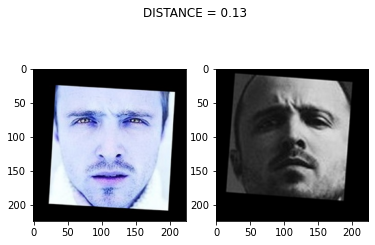

In [217]:
plt.suptitle(f'DISTANCE = {DIST_BW_IMAGES(EMBEDDINGS[1], EMBEDDINGS[50]):.2f}')

plt.subplot(121)
plt.imshow(IMAGE_DATA[1])
plt.subplot(122)
plt.imshow(IMAGE_DATA[50])

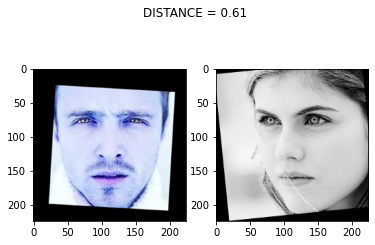

In [218]:
plt.suptitle(f'DISTANCE = {DIST_BW_IMAGES(EMBEDDINGS[1], EMBEDDINGS[128]):.2f}')

plt.subplot(121)
plt.imshow(IMAGE_DATA[1])
plt.subplot(122)
plt.imshow(IMAGE_DATA[128])

# 6. Use PCA for dimensionality reduction.

    * BEFORE GOING TO DIMENSIONALITY REDUCTION, ENCODE THE TARGETS AND SCALE THE FEATURES.
    
    * SPLIT THE DATA INTO TEST AND TRAIN.
    
    * LABEL ENCODE THE TARGET VARIABLES Y_TRAIN AND Y_TEST
    
    * SCALE THE FEATURES X_TRAIN AND X_TEST

In [221]:
TRAIN_INDEX = np.arange(META_DATA.shape[0]) % 11 != 0
TEST_INDEX = np.arange(META_DATA.shape[0]) %11 == 0


X_TRAIN = EMBEDDINGS[TRAIN_INDEX]

X_TEST = EMBEDDINGS[TEST_INDEX]

TARGETS = np.array([m.name for m in META_DATA])

Y_TRAIN = TARGETS[TRAIN_INDEX]

Y_TEST = TARGETS[TEST_INDEX]

In [223]:
print('X_TRAIN SHAPE: ',X_TRAIN.shape)
print('Y_TRAIN SHAPE: ',Y_TRAIN.shape)
print('X_TEST SHAPE: ',X_TEST.shape)
print('Y_TEST SHAPE: ',Y_TEST.shape)

X_TRAIN SHAPE:  (7489, 2622)
Y_TRAIN SHAPE:  (7489,)
X_TEST SHAPE:  (749, 2622)
Y_TEST SHAPE:  (749,)


In [225]:
LE = LabelEncoder()

Y_TRAIN = LE.fit_transform(Y_TRAIN)

Y_TEST = LE.fit_transform(Y_TEST)

In [227]:
SS = StandardScaler()

X_TRAIN_S = SS.fit_transform(X_TRAIN)

X_TEST_S = SS.fit_transform(X_TEST)

In [310]:
n_components=128

PCA_MODEL = PCA(n_components=n_components,svd_solver="randomized",whiten = True)

X_TRAIN_PCA = PCA_MODEL.fit_transform(X_TRAIN_S)

X_TEST_PCA = PCA_MODEL.fit_transform(X_TEST_S)

# 7. Build an SVM classifier in order to map each image to its right person.

In [311]:
from sklearn.svm import SVC

SVC_MODEL = SVC(kernel = 'linear')

SVC_MODEL.fit(X_TRAIN_PCA, Y_TRAIN)

SVC(kernel='linear')

In [320]:
from sklearn.metrics import accuracy_score

Y_PRED = SVC_MODEL.predict(X_TEST_PCA)

Y_PRED_ENC = LE.inverse_transform(Y_PRED)

accuracy_score(Y_TEST,Y_PRED)

0.030707610146862484

# 8. Import and display the the test images.

In [313]:
TEST_IMAGE1 = cv2.imread('DwayneJohnson4.jpg')
TEST_IMAGE1 = cv2.resize(TEST_IMAGE1,(224,224))

TEST_IMAGE2 = cv2.imread('BenedictCumberbatch9.jpg')
TEST_IMAGE2 = cv2.resize(TEST_IMAGE2,(224,224))

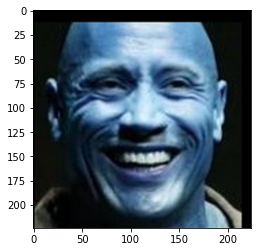

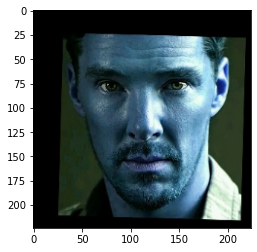

In [314]:
plt.imshow(TEST_IMAGE1)
plt.show()

plt.imshow(TEST_IMAGE2)
plt.show()

# 9. Use the trained SVM model to predict the face on both test images.

In [315]:
EMBED_TEST1 = VGG_FACE_EMBEDDING.predict(np.expand_dims(TEST_IMAGE1, axis = 0))[0]

EMBED_TEST2 = VGG_FACE_EMBEDDING.predict(np.expand_dims(TEST_IMAGE2, axis = 0))[0]

1/1 [==============================] - 1s 783ms/step


In [370]:
TEST_SS1 = SS.fit_transform(EMBED_TEST1.reshape(1, -1))

TEST_SS2 = SS.fit_transform(EMBED_TEST2.reshape(1, -1))

In [373]:
TEST1_PCA = PCA().fit_transform(TEST_SS1)

TEST2_PCA = PCA().fit_transform(TEST_SS2)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:525: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S**2) / (n_samples - 1)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:525: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S**2) / (n_samples - 1)
